# Gaussian filter (blur) the attention maps

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import torch
import cv2
import PIL.Image

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The image is RGBA, with only data in the red channel (alpha is 255 everywhere). How can we detect the former is happening?

wrong_ss = PIL.Image.open('./test_data/ttt/ayoo/ss_central001070.png').convert('RGB')
wrong_ss = np.array(wrong_ss)

In [3]:
len(PIL.Image.open('./test_data/ttt/ayoo/ss_central001070.png').getcolors())

16

In [4]:
segmented_img = cv2.imread('./test_data/ttt/ayoo/ss_central001070.png', cv2.IMREAD_UNCHANGED)  # BGRA
segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGRA2RGB)

In [5]:
segmented_img = cv2.imread('./test_data/ttt/ayoo/ss_central001070.png', cv2.IMREAD_UNCHANGED)
segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGRA2RGB)

In [6]:
segmented_img

array([[[13,  0,  0],
        [13,  0,  0],
        [13,  0,  0],
        ...,
        [13,  0,  0],
        [13,  0,  0],
        [13,  0,  0]],

       [[13,  0,  0],
        [13,  0,  0],
        [13,  0,  0],
        ...,
        [13,  0,  0],
        [13,  0,  0],
        [13,  0,  0]],

       [[13,  0,  0],
        [13,  0,  0],
        [13,  0,  0],
        ...,
        [13,  0,  0],
        [13,  0,  0],
        [13,  0,  0]],

       ...,

       [[ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        ...,
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0]],

       [[ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        ...,
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0]],

       [[ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0],
        ...,
        [ 7,  0,  0],
        [ 7,  0,  0],
        [ 7,  0,  0]]], dtype=uint8)

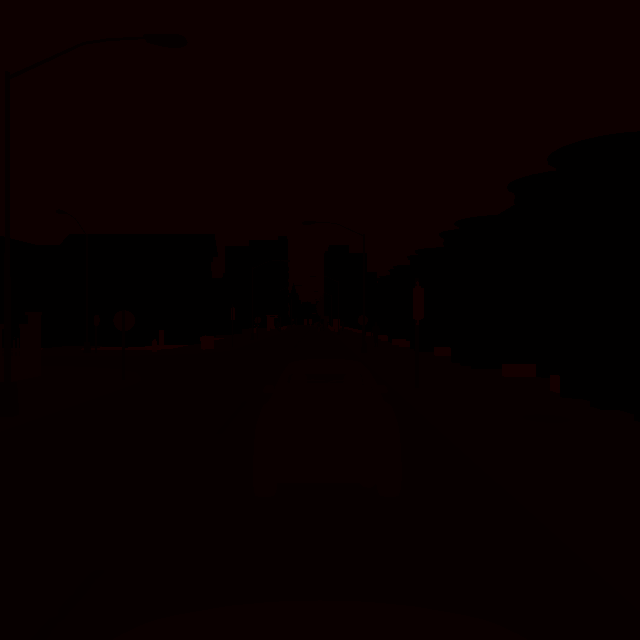

In [19]:
from dataloaders import transforms

img = cv2.imread('./test_data/ttt/ayoo/ss_central001070.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
if max(img.flatten()) < max(transforms.ss_classes):
    # All the info is in the red channel, so use the dict to map to the correct class
    # Replace the three channels with the corresponding values in the dict
    for k, v in transforms.ss_classes.items():
        img[img[:, :, 0] == k] = v

PIL.Image.fromarray(img)

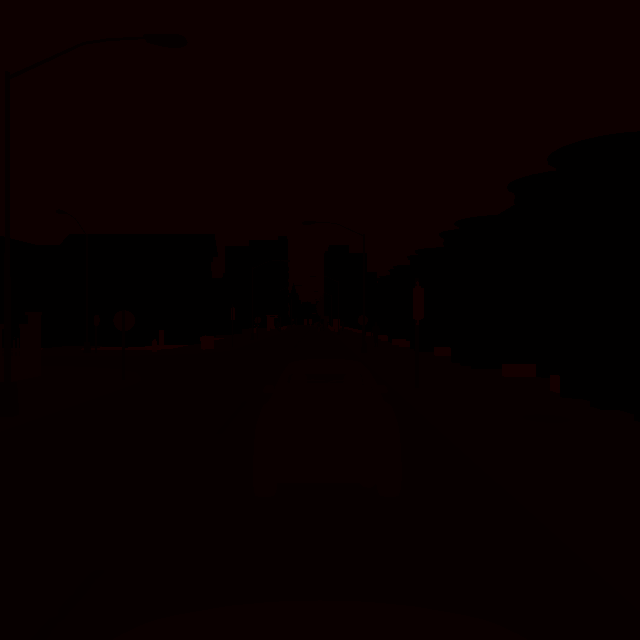

In [9]:
PIL.Image.fromarray(img)

In [10]:
segmented_img2 = cv2.imread('./test_data/ttt/ayoo/ss_central001470.png', cv2.IMREAD_UNCHANGED)
segmented_img2 = cv2.cvtColor(segmented_img2, cv2.COLOR_BGRA2RGB)

False

## Average masks/virtual attention maps

Let's get the average virtual attention maps, in case there's an imbalance happening during training.

In [1]:
import glob
import os

# Get the dataset root
dataset_root = '/datafast/Datasets/dporres/CARLA/Roach_carla0913_fps10_640x640_3cam_attention'

# Find all the images in the dataset that have 'virtual_attention' in their name, separate by camera
virtual_attention_imgs = glob.glob(os.path.join(dataset_root, '**/*/virtual_attention*'), recursive=True)

virtual_attention_left_imgs = [img for img in virtual_attention_imgs if 'left' in img]
virtual_attention_central_imgs = [img for img in virtual_attention_imgs if 'central' in img]
virtual_attention_right_imgs = [img for img in virtual_attention_imgs if 'right' in img]

In [2]:
len(virtual_attention_left_imgs) == len(virtual_attention_central_imgs) == len(virtual_attention_right_imgs)

True

In [4]:
import cv2

im = cv2.imread(virtual_attention_left_imgs[0], cv2.IMREAD_UNCHANGED)

In [6]:
import cv2

img_shape = cv2.imread(virtual_attention_left_imgs[0], cv2.IMREAD_UNCHANGED).shape
num_images = len(virtual_attention_left_imgs)

# Create a numpy array to store the image values, then finally average them
virtual_attention_left_imgs_np = np.zeros((num_images, *img_shape), dtype=np.uint8)
virtual_attention_central_imgs_np = np.zeros((num_images, *img_shape), dtype=np.uint8)
virtual_attention_right_imgs_np = np.zeros((num_images, *img_shape), dtype=np.uint8)

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool

def read_image(path):
    return cv2.imread(path, cv2.IMREAD_UNCHANGED)

with Pool(os.cpu_count()) as p:
    left_imgs = list(tqdm(p.imap(read_image, virtual_attention_left_imgs), total=num_images))
    central_imgs = list(tqdm(p.imap(read_image, virtual_attention_central_imgs), total=num_images))
    right_imgs = list(tqdm(p.imap(read_image, virtual_attention_right_imgs), total=num_images))

100%|██████████| 302198/302198 [07:36<00:00, 661.76it/s] 


: 

In [ ]:
average_left = np.mean(virtual_attention_left_imgs_np, axis=0).astype(np.uint8)
average_central = np.mean(virtual_attention_central_imgs_np, axis=0).astype(np.uint8)
average_right = np.mean(virtual_attention_right_imgs_np, axis=0).astype(np.uint8)

dddd

In [9]:
import numpy as np
import cv2
from tqdm import tqdm
from multiprocessing import Pool, Manager

def read_and_store(args):
    idx, path, shared_list, shape = args
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shared_list[idx] = img

# Using Manager to create shared lists
manager = Manager()
shared_left = manager.list([np.zeros(img_shape, dtype=np.uint8) for _ in range(num_images)])
shared_central = manager.list([np.zeros(img_shape, dtype=np.uint8) for _ in range(num_images)])
shared_right = manager.list([np.zeros(img_shape, dtype=np.uint8) for _ in range(num_images)])

with Pool() as pool:
    left_args = [(idx, path, shared_left, img_shape) for idx, path in enumerate(virtual_attention_left_imgs)]
    central_args = [(idx, path, shared_central, img_shape) for idx, path in enumerate(virtual_attention_central_imgs)]
    right_args = [(idx, path, shared_right, img_shape) for idx, path in enumerate(virtual_attention_right_imgs)]

    list(tqdm(pool.imap_unordered(read_and_store, left_args), total=num_images))
    list(tqdm(pool.imap_unordered(read_and_store, central_args), total=num_images))
    list(tqdm(pool.imap_unordered(read_and_store, right_args), total=num_images))

# Convert the managed list back to numpy arrays
virtual_attention_left_imgs_np = np.array(shared_left)
virtual_attention_central_imgs_np = np.array(shared_central)
virtual_attention_right_imgs_np = np.array(shared_right)


: 

## Come back later to the average

Dunno why it's so hard to do it but whatever

Now, we focus on doing a Gaussian blur of the given attention maps:

In [3]:
import scipy.ndimage
import numpy as np
import cv2
from tqdm import tqdm

def blur_image(img, sigma=1):
    return scipy.ndimage.gaussian_filter(img, sigma=sigma)

def blur_image_cv2(img, sigma=1):
    return cv2.GaussianBlur(img, (0, 0), sigma)

In [4]:
img = cv2.imread('./test_data/virtual_attentions/virtual_attention_central_000080.jpg', cv2.IMREAD_UNCHANGED)

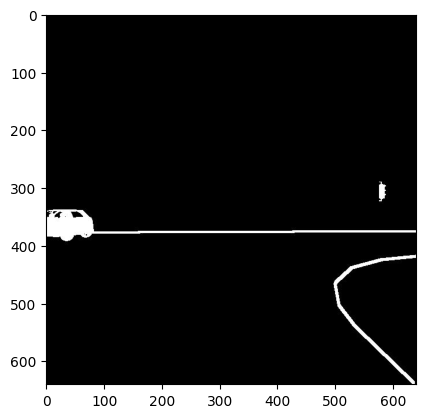

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.show()

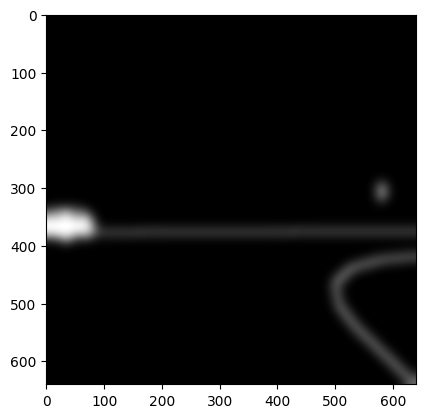

In [6]:
# Now blur it
blurred = blur_image(img, sigma=10)
plt.imshow(blurred, cmap='gray')
plt.show()

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


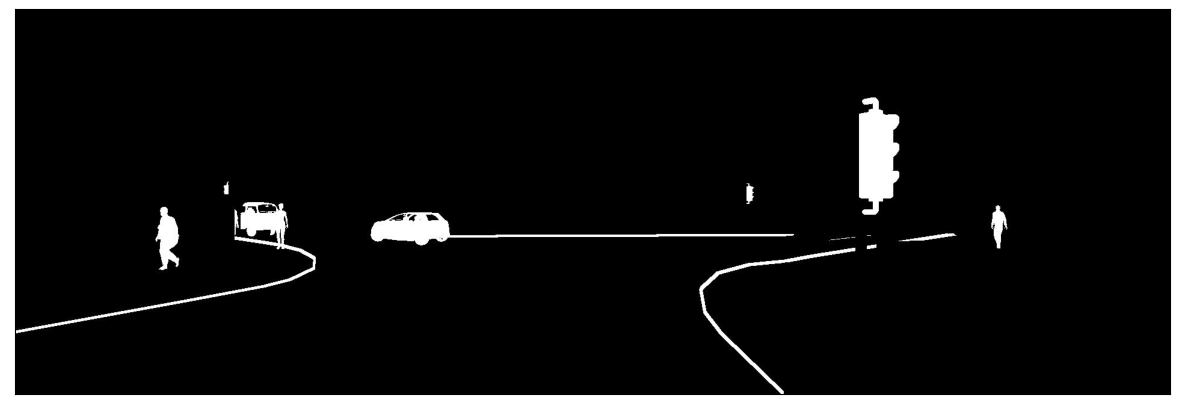

In [7]:
# Join the three images into one (horizontal stack); no need to resize
left = cv2.imread('./test_data/virtual_attentions/virtual_attention_left_000080.jpg', cv2.IMREAD_UNCHANGED)
central = cv2.imread('./test_data/virtual_attentions/virtual_attention_central_000080.jpg', cv2.IMREAD_UNCHANGED)
right = cv2.imread('./test_data/virtual_attentions/virtual_attention_right_000080.jpg', cv2.IMREAD_UNCHANGED)

stack = np.hstack([left, central, right])

plt.figure(figsize=(15, 5))
plt.imshow(stack, cmap='gray')
plt.axes().set_xticks([])
plt.axes().set_yticks([])
plt.show()

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


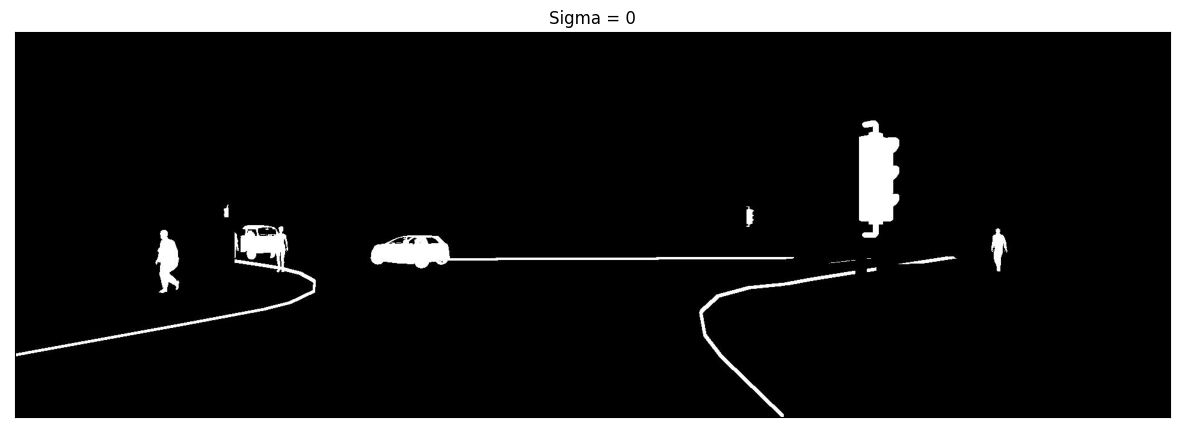

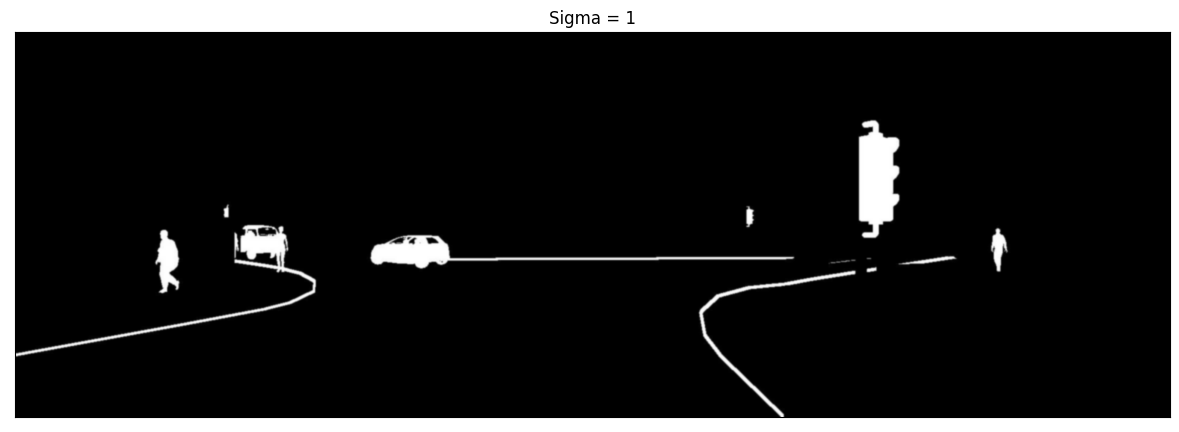

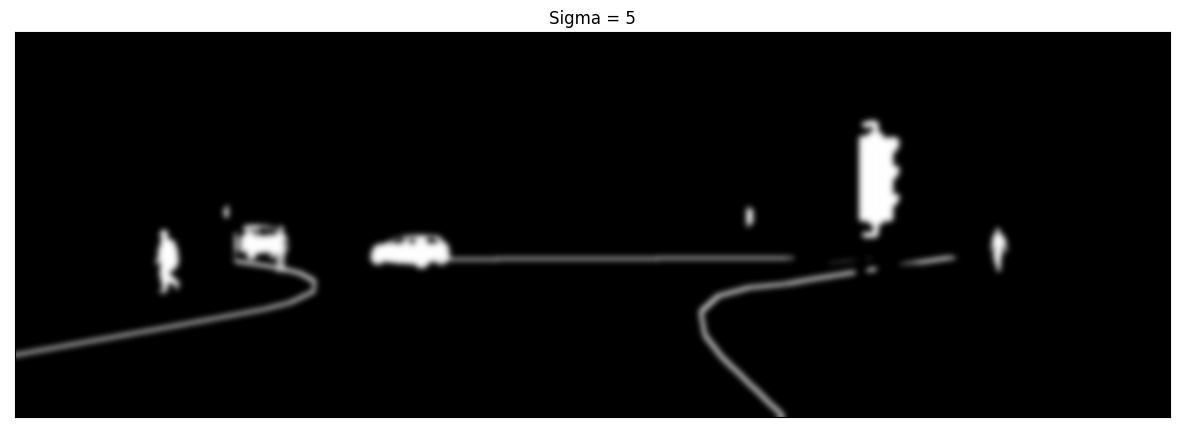

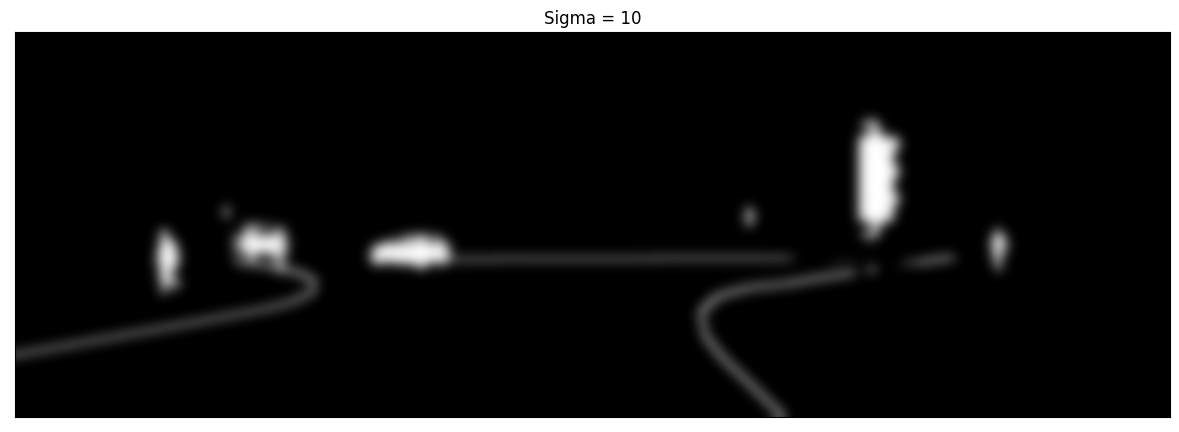

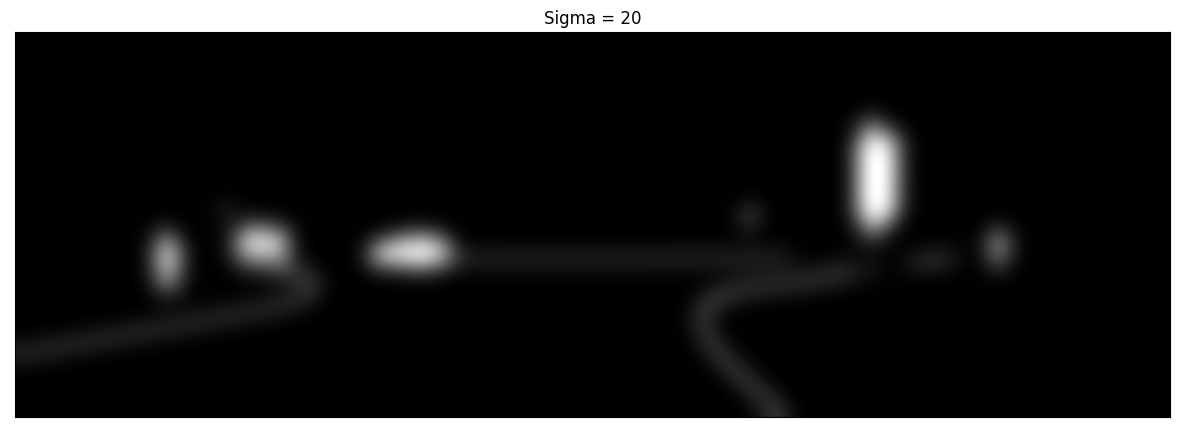

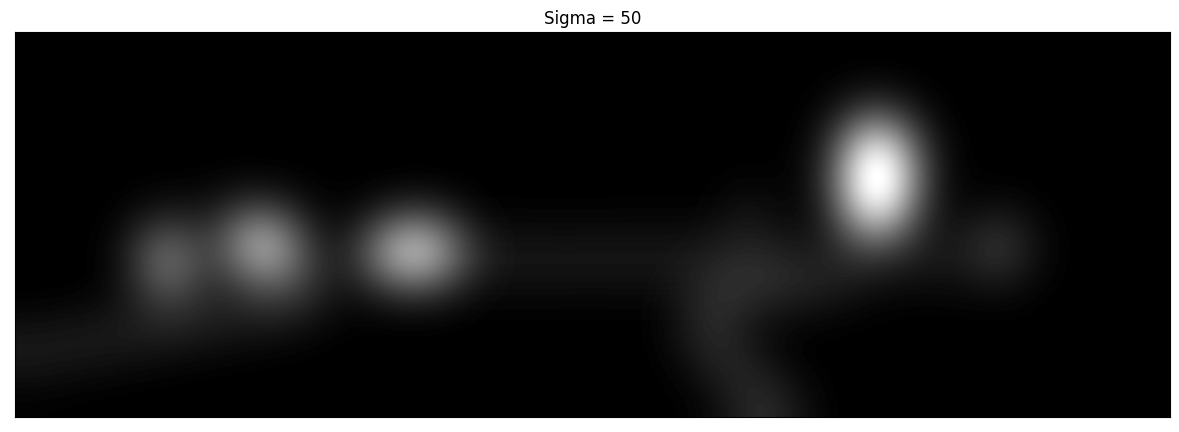

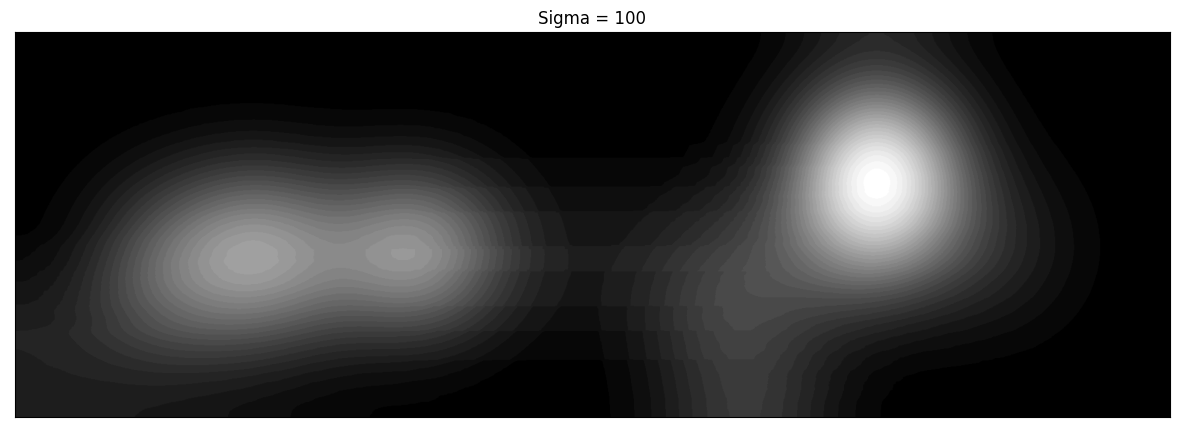

In [8]:
sigmas = [0, 1, 5, 10, 20, 50, 100]

for sigma in sigmas:
    blurred = blur_image(stack, sigma=sigma)
    plt.figure(figsize=(15, 5))
    plt.imshow(blurred, cmap='gray')
    plt.axes().set_xticks([])
    plt.axes().set_yticks([])
    plt.title(f'Sigma = {sigma}')
    plt.show()

In [9]:
stack.sum()

7910834

In [10]:
blurred.max()

35

In [11]:
maxblur = blurred

maxblur = (maxblur - maxblur.min()) / (maxblur.max() - maxblur.min())
maxblur = maxblur ** 2


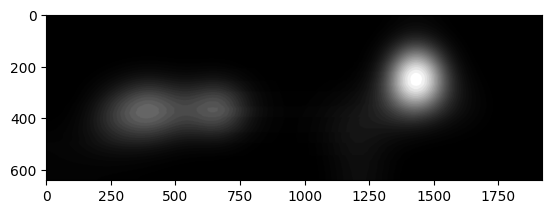

In [12]:
plt.imshow(maxblur, cmap='gray')

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == "":


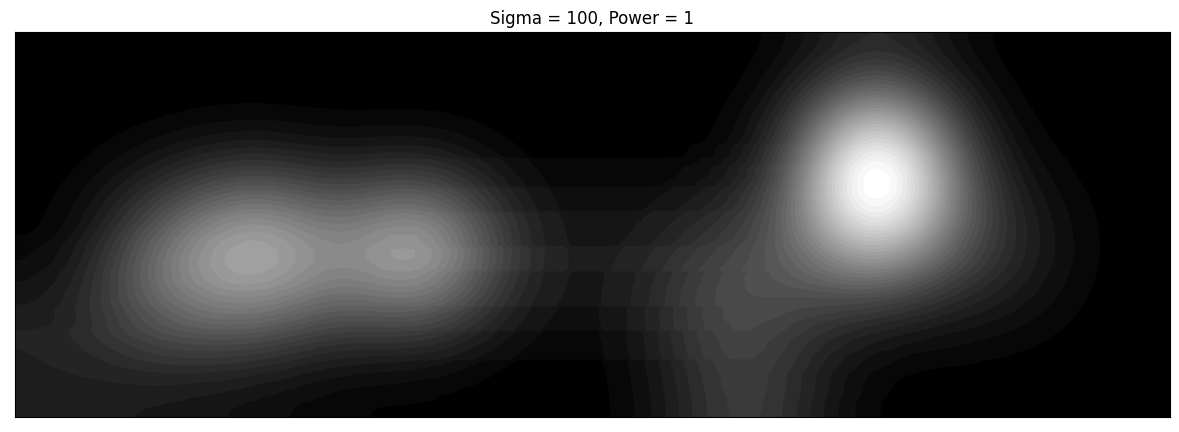

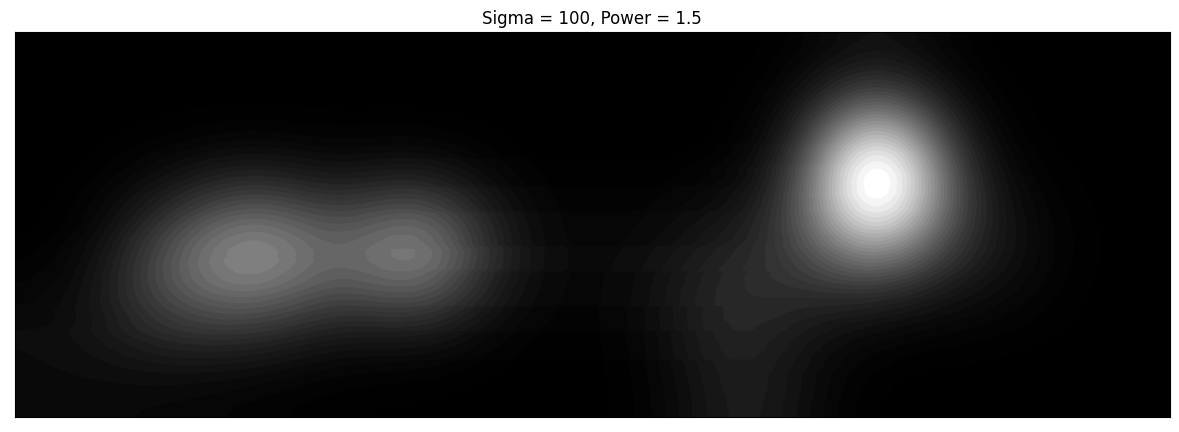

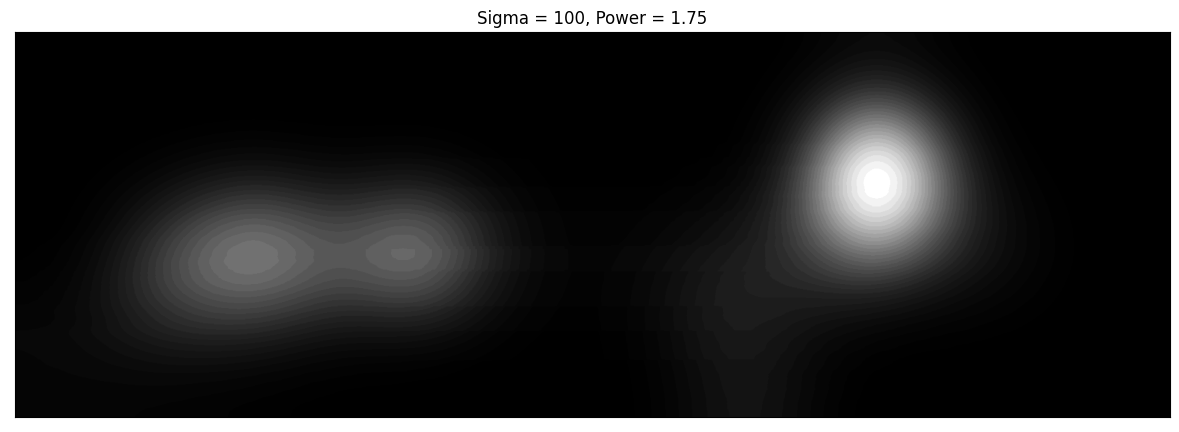

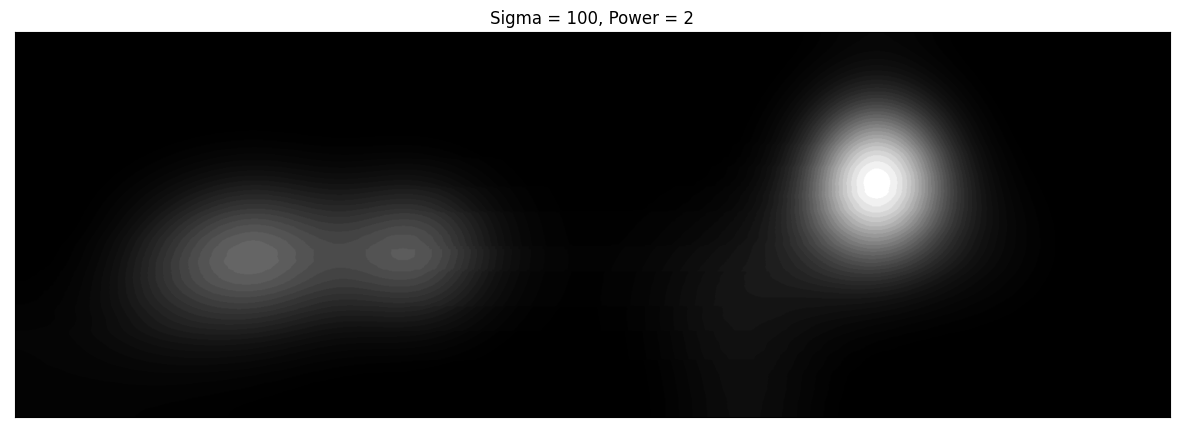

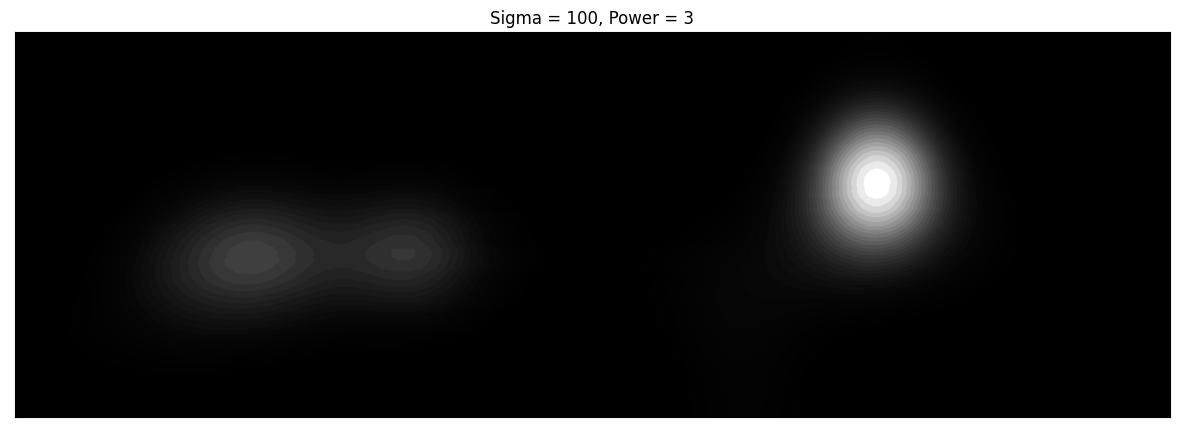

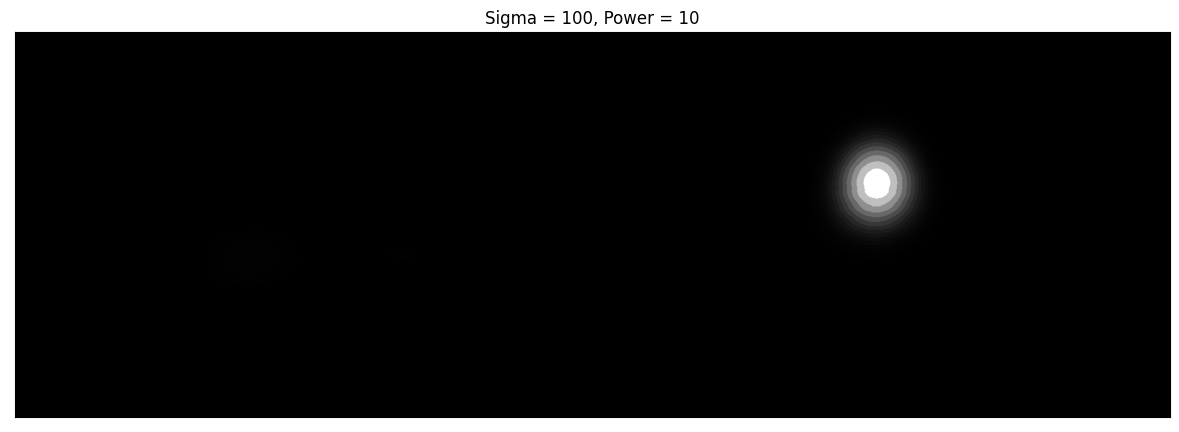

In [13]:
powers = [1, 1.5, 1.75, 2, 3, 10]

for pow in powers:
    maxblur = blurred

    maxblur = (maxblur - maxblur.min()) / (maxblur.max() - maxblur.min())
    maxblur = maxblur ** pow

    plt.figure(figsize=(15, 5))
    plt.imshow(maxblur, cmap='gray')
    plt.axes().set_xticks([])
    plt.axes().set_yticks([])
    plt.title(f'Sigma = 100, Power = {pow}')
    plt.show()

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


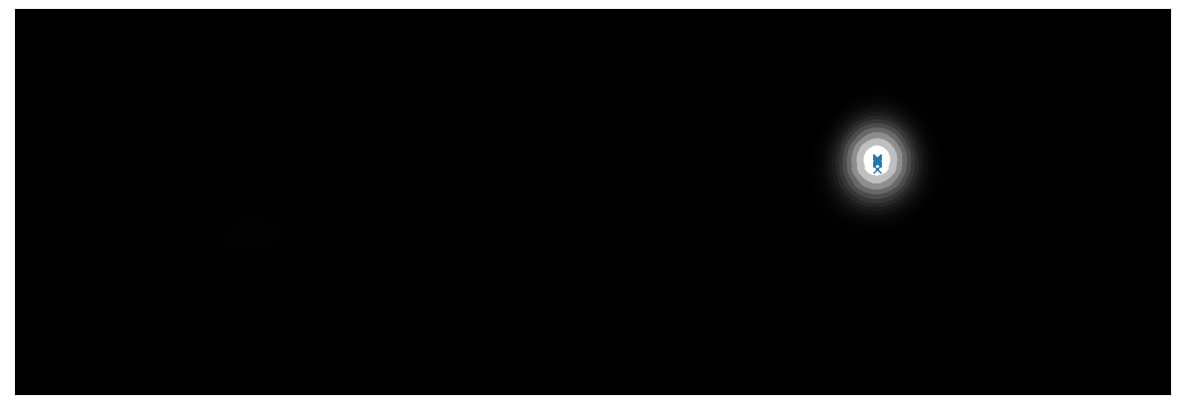

In [14]:
import scipy.signal

# Find the peaks using scipy.signal.find_peaks
peaks, properties = scipy.signal.find_peaks(maxblur.flatten(), height=1.0, width=84, prominence=1)

# Plot the peaks in the 2d image
plt.figure(figsize=(15, 5))
plt.imshow(maxblur, cmap='gray')
plt.plot(peaks % maxblur.shape[1], peaks // maxblur.shape[1], 'x')
plt.axes().set_xticks([])
plt.axes().set_yticks([])
plt.show()

In [15]:
peaks

array([475672, 477592, 479512, 481432, 483352, 485272, 487192, 489112,
       491032, 510232])

In [16]:
properties['prominences'].max()

1.0

In [23]:
# Let's downsample the image to 30x10, then upscale it back to the original size with the following algorithms:

# - Nearest neighbor
# - Bilinear
# - Bicubic
# - Lanczos
# - Area

# Then we'll blur the upscaled images with sigma=100 and see which one gives the best results

# First, downsample the image to 30x10

# Nearest neighbor
downsampled_nn = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_NEAREST)
upscaled_nn = cv2.resize(downsampled_nn, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_NEAREST)

# Bilinear
downsampled_bilinear = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_LINEAR)
upscaled_bilinear = cv2.resize(downsampled_bilinear, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_LINEAR)

# Bicubic
downsampled_bicubic = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_CUBIC)
upscaled_bicubic = cv2.resize(downsampled_bicubic, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_CUBIC)

# Lanczos
downsampled_lanczos = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_LANCZOS4)
upscaled_lanczos = cv2.resize(downsampled_lanczos, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_LANCZOS4)

# Area
downsampled_area = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_AREA)
upscaled_area = cv2.resize(downsampled_area, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_AREA)

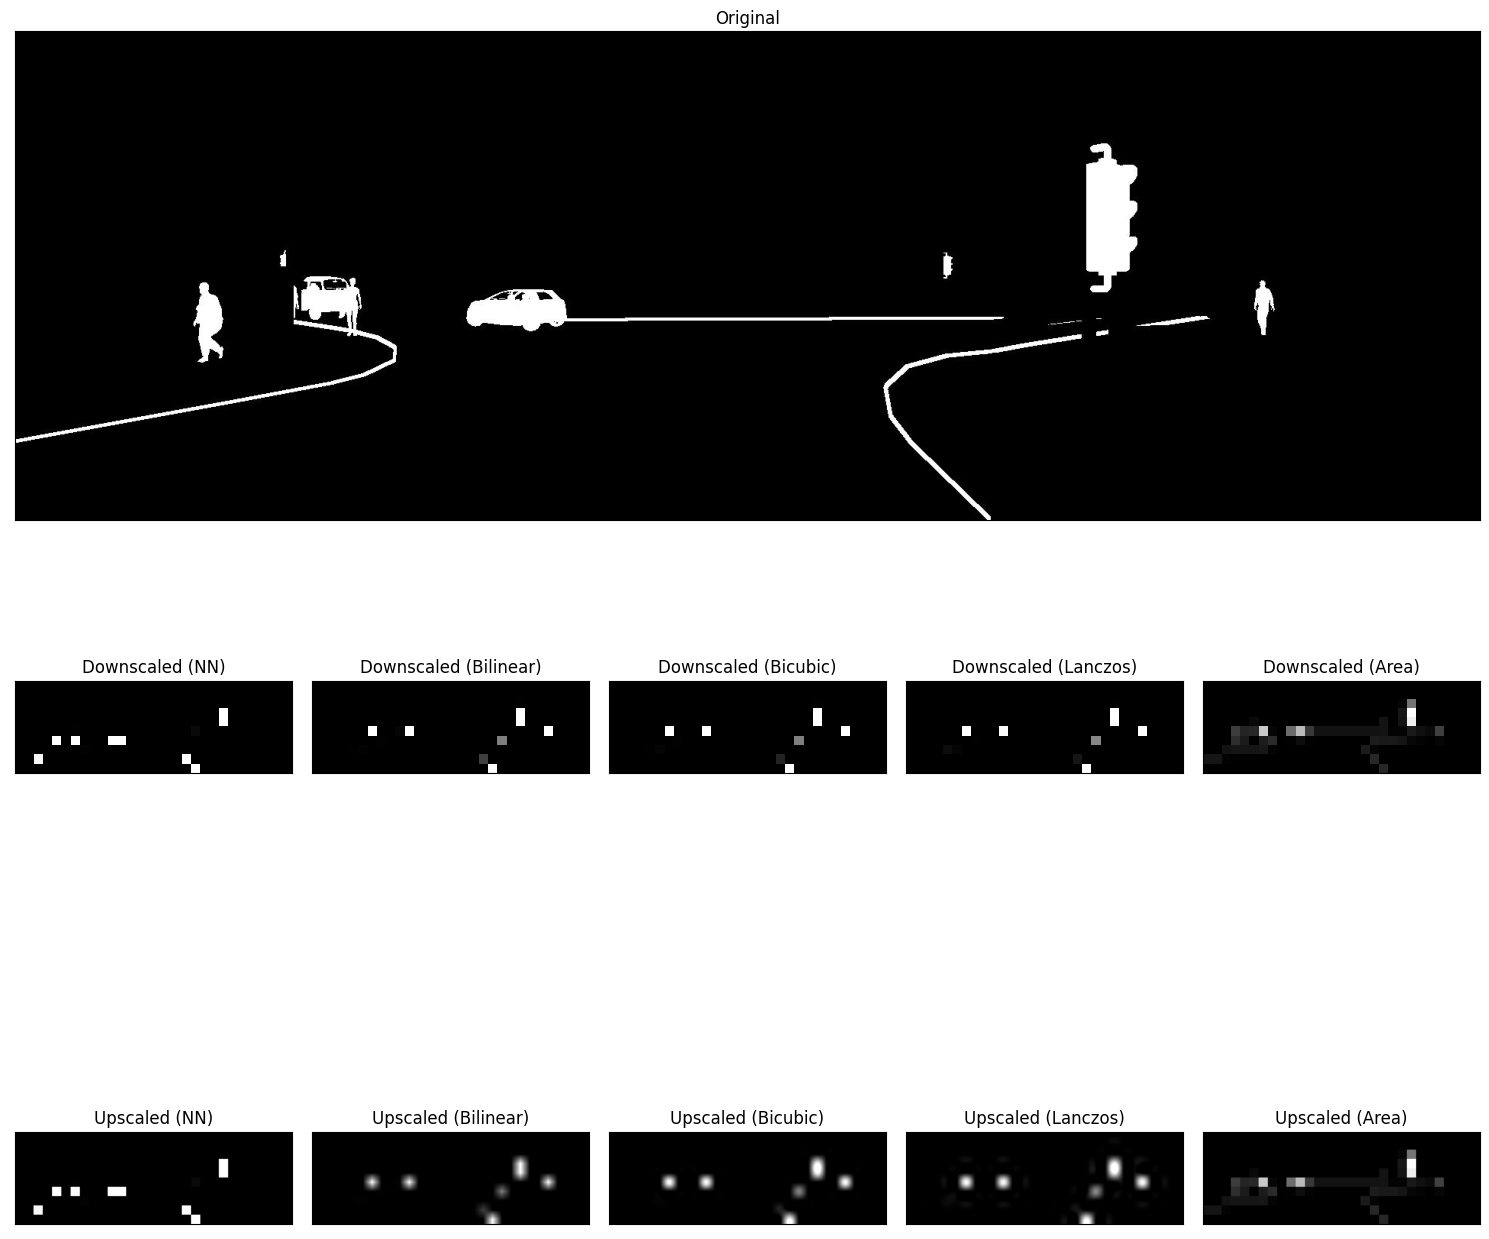

In [33]:
# Display both downscaled and upscaled images
# At the top, show the original image (stack)
# At the bottom, show the downscaled and upscaled images
# Remove axes and ticks

plt.figure(figsize=(15, 15))
plt.subplot(3, 5, (1, 5))
plt.imshow(stack, cmap='gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.subplot(3, 5, 6)
plt.xticks([])
plt.yticks([])
plt.imshow(downsampled_nn, cmap='gray')
plt.title('Downscaled (NN)')
plt.subplot(3, 5, 7)
plt.xticks([])
plt.yticks([])
plt.imshow(downsampled_bilinear, cmap='gray')
plt.title('Downscaled (Bilinear)')
plt.subplot(3, 5, 8)
plt.xticks([])
plt.yticks([])
plt.imshow(downsampled_bicubic, cmap='gray')
plt.title('Downscaled (Bicubic)')
plt.subplot(3, 5, 9)
plt.xticks([])
plt.yticks([])
plt.imshow(downsampled_lanczos, cmap='gray')
plt.title('Downscaled (Lanczos)')
plt.subplot(3, 5, 10)
plt.xticks([])
plt.yticks([])
plt.imshow(downsampled_area, cmap='gray')
plt.title('Downscaled (Area)')
plt.subplot(3, 5, 11)
plt.xticks([])
plt.yticks([])
plt.imshow(upscaled_nn, cmap='gray')
plt.title('Upscaled (NN)')
plt.xticks([])
plt.yticks([])
plt.subplot(3, 5, 12)
plt.imshow(upscaled_bilinear, cmap='gray')
plt.title('Upscaled (Bilinear)')
plt.xticks([])
plt.yticks([])
plt.subplot(3, 5, 13)
plt.imshow(upscaled_bicubic, cmap='gray')
plt.title('Upscaled (Bicubic)')
plt.xticks([])
plt.yticks([])
plt.subplot(3, 5, 14)
plt.imshow(upscaled_lanczos, cmap='gray')
plt.title('Upscaled (Lanczos)')
plt.xticks([])
plt.yticks([])
plt.subplot(3, 5, 15)
plt.imshow(upscaled_area, cmap='gray')
plt.title('Upscaled (Area)')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

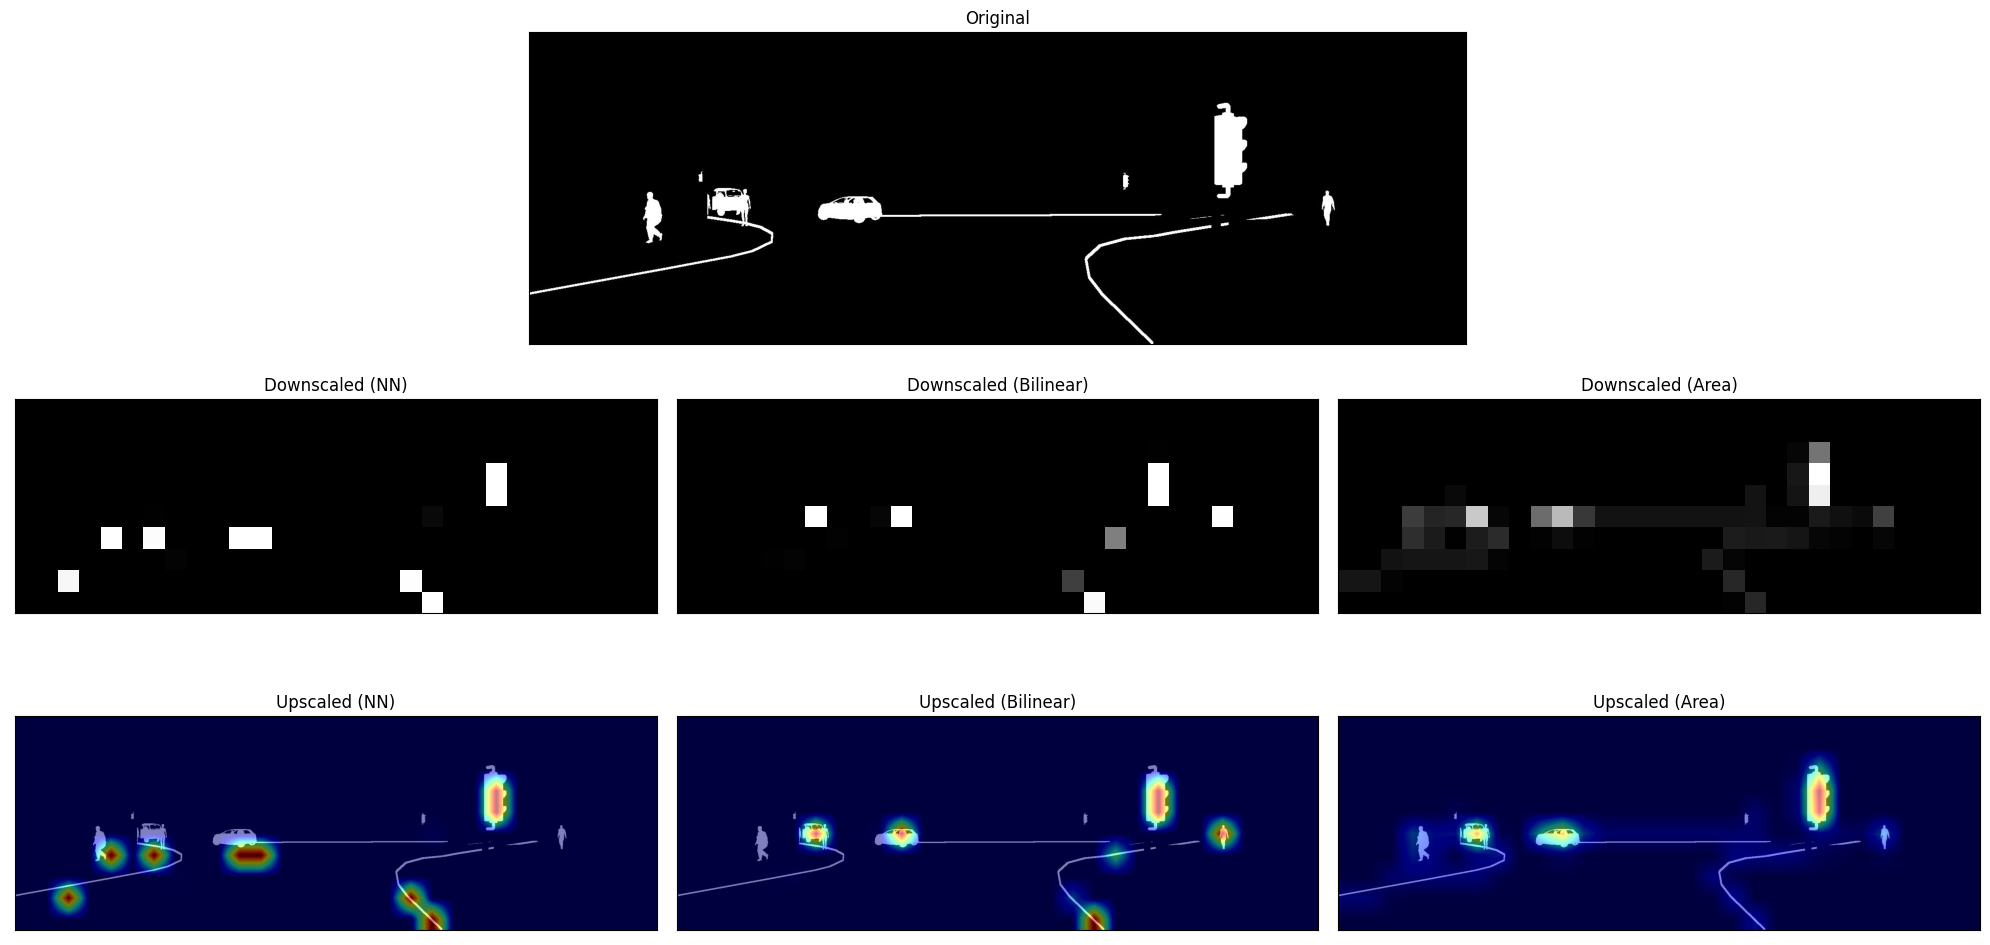

In [47]:
# Let's turn this into a loop. First setup a dictionary with all the interpolation methods
# and their corresponding names

interpolation_methods = {
    'NN': cv2.INTER_NEAREST,
    'Bilinear': cv2.INTER_LINEAR,
    'Area': cv2.INTER_AREA
}

# Then loop over the dictionary, downscale and upscale the image, and store the results in a list
# Finally, plot the results

downscaled = []
upscaled = []

for name, method in interpolation_methods.items():
    downsampled = cv2.resize(stack, (30, 10), interpolation=method)
    upsampled = cv2.resize(downsampled, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_LINEAR)

    downscaled.append(downsampled)
    upscaled.append(upsampled)

plt.figure(figsize=(20, 10))
plt.subplot(3, 3, (1, 3))
plt.imshow(stack, cmap='gray')
plt.title('Original')
plt.xticks([])
plt.yticks([])

for i, (down, up) in enumerate(zip(downscaled, upscaled)):
    up = (up - up.min()) / (up.max() - up.min())
    plt.subplot(3, 3, 4 + i)
    plt.imshow(down, cmap='gray')
    plt.title(f'Downscaled ({list(interpolation_methods.keys())[i]})')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(3, 3, 7 + i)
    # plt.imshow(up, cmap='gray')
    plt.title(f'Upscaled ({list(interpolation_methods.keys())[i]})')
    plt.imshow(stack, cmap='gray')
    plt.imshow(up, cmap='jet', alpha=0.5)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


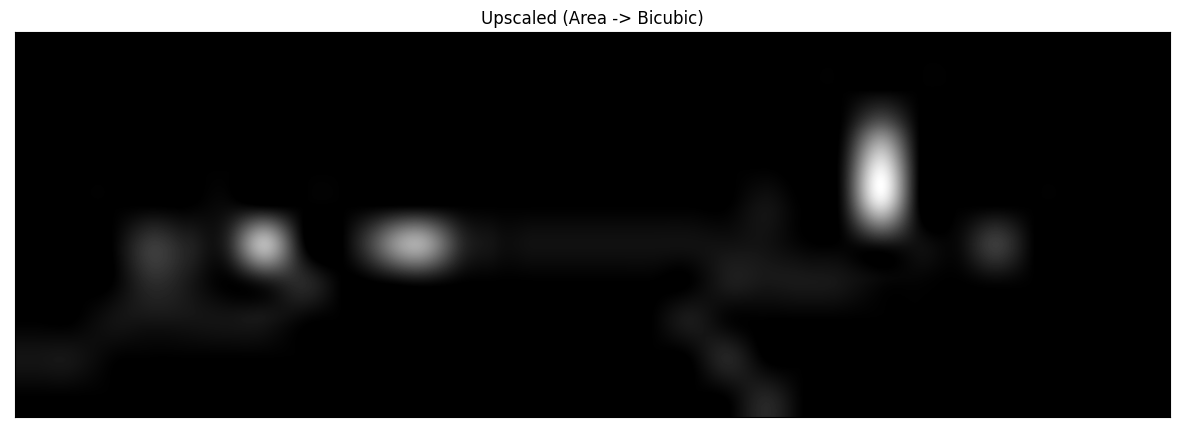

In [37]:
# Now, downscale with InterArea, then upscale with Bicubic
downsampled = cv2.resize(stack, (30, 10), interpolation=cv2.INTER_AREA)
upsampled = cv2.resize(downsampled, (stack.shape[1], stack.shape[0]), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(15, 5))
plt.imshow(upsampled, cmap='gray')
plt.title('Upscaled (Area -> Bicubic)')
plt.xticks([])
plt.yticks([])
plt.show()

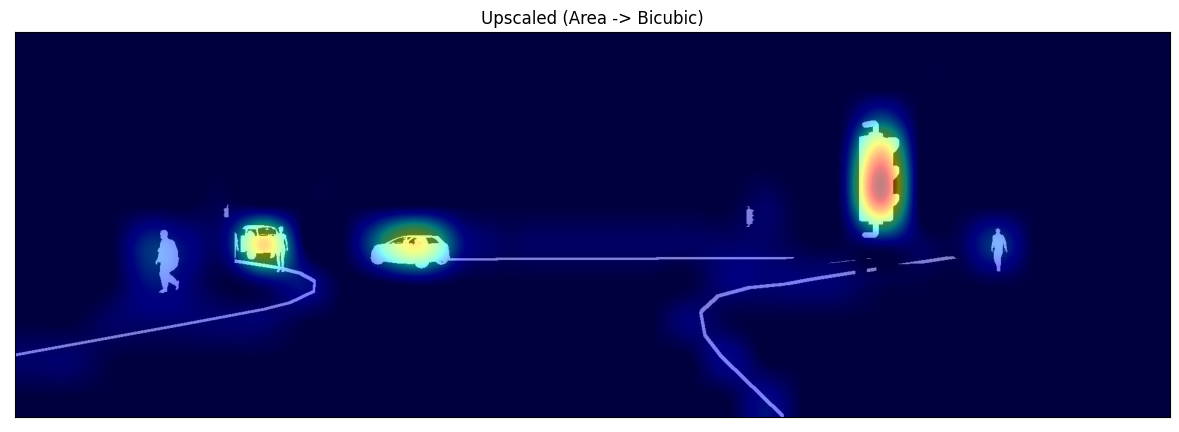

In [38]:
# Let's display it as a heatmap on top of the original image
# First, normalize the heatmap

heatmap = upsampled
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


plt.figure(figsize=(15, 5))
plt.imshow(stack, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Upscaled (Area -> Bicubic)')
plt.xticks([])
plt.yticks([])
plt.show()